# 人民日报文章内容分析

## 1.数据获取 

In [216]:
import requests
import bs4
import os
import datetime
import time


def fetch_url(url):
    """
        功能：访问 url 的网页，获取网页内容并返回
    :param url: 目标网页的 url
    :return: 目标网页的 html 内容
    """
    headers = {
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.106 Safari/537.36',
    }

    r = requests.get(url, headers=headers)
    r.raise_for_status()
    r.encoding = r.apparent_encoding
    return r.text


def get_page_list(year, month, day):
    """
        功能：获取当天报纸的各版面的链接列表
    :param year: 年 改变年月日拼接成需要爬取的url
    :param month: 月
    :param day: 日
    :return: 返回当天报纸的各版面的链接列表
    """
    url = 'http://paper.people.com.cn/rmrb/html/' + year + '-' + month + '/' + day + '/nbs.D110000renmrb_01.htm'
    html = fetch_url(url)
    bs_obj = bs4.BeautifulSoup(html, 'html.parser')
    temp = bs_obj.find('div', attrs={'id': 'pageList'})
    if temp:
        page_list = temp.ul.find_all('div', attrs={'class': 'right_title-name'})
    else:
        page_list = bs_obj.find('div', attrs={'class': 'swiper-container'}).find_all('div',
                                                                                     attrs={'class': 'swiper-slide'})
    link_list = []
    for page in page_list:
        link = page.a["href"]
        url = 'http://paper.people.com.cn/rmrb/html/' + year + '-' + month + '/' + day + '/' + link
        link_list.append(url)
    return link_list


def get_title_list(year, month, day, pageUrl):
    """
        功能：获取报纸某一版面的文章链接列表
    :param year: 年
    :param month: 月
    :param day: 日
    :param pageUrl: 该版面的链接
    :return:
    """
    html = fetch_url(pageUrl)
    bs_obj = bs4.BeautifulSoup(html, 'html.parser')
    temp = bs_obj.find('div', attrs={'id': 'titleList'})
    if temp:
        title_list = temp.ul.find_all('li')
    else:
        title_list = bs_obj.find('ul', attrs={'class': 'news-list'}).find_all('li')
    link_list = []

    for title in title_list:
        temp_list = title.find_all('a')
        for temp in temp_list:
            link = temp["href"]
            if 'nw.D110000renmrb' in link:
                url = 'http://paper.people.com.cn/rmrb/html/' + year + '-' + month + '/' + day + '/' + link
                link_list.append(url)
    return link_list


def get_content(html):
    """
        功能：解析 HTML 网页，获取新闻的文章内容
    :param html: html 网页内容
    :return: 标题+内容
    """
    bs_obj = bs4.BeautifulSoup(html, 'html.parser')

    # 获取文章 标题
    title = bs_obj.h3.text + '\n' + bs_obj.h1.text + '\n' + bs_obj.h2.text + '\n'
    # print(title)

    # 获取文章 内容
    p_list = bs_obj.find('div', attrs={'id': 'ozoom'}).find_all('p')
    content = ''
    for p in p_list:
        content += p.text + '\n'
    # print(content)

    resp = title + content
    return resp


def save_file(content, path, filename):
    """
        功能：将文章内容 content 保存到本地文件中
    :param content: 要保存的内容
    :param path: 路径
    :param filename: 文件名
    :return:
    """
    # 如果没有该文件夹，则自动生成
    if not os.path.exists(path):
        os.makedirs(path)
        # print('爬取到文章，正在下载中...')

    # 保存文件
    with open(path + filename, 'w', encoding='utf-8') as f:
        f.write(content)
    # print('爬取到文章，正在下载中...')
    # print('文章已写入：' + path)


def download_rmrb(year, month, day, destdir):
    """
        功能：爬取《人民日报》网站某年,某月,某日的新闻内容，并保存在指定目录下
    :param year: 年
    :param month: 月
    :param day: 日
    :param destdir: 文件保存的根目录
    :return:
    """
    page_list = get_page_list(year, month, day)
    for page in page_list:
        title_list = get_title_list(year, month, day, page)
        for url in title_list:
            # 获取新闻文章内容
            html = fetch_url(url)
            content = get_content(html)
            # 生成保存的文件路径及文件名
            temp = url.split('_')[2].split('.')[0].split('-')
            page_no = temp[1]
            title_no = temp[0] if int(temp[0]) >= 10 else '0' + temp[0]
            path = destdir + '/' + year + month + day + '/'
            file_name = year + month + day + '-' + page_no + '-' + title_no + '.txt'

            # 保存文件
            save_file(content, path, file_name)
            time.sleep(120)  # 休眠120s


def gen_dates(b_date, days):
    day = datetime.timedelta(days=1)
    for i in range(days):
        yield b_date + day * i


def get_date_list(beginDate, endDate):
    """
        获取日期列表
    :param beginDate: 开始日期
    :param endDate: 结束日期
    :return:
    """
    start = datetime.datetime.strptime(beginDate, "%Y%m%d")
    end = datetime.datetime.strptime(endDate, "%Y%m%d")

    data = []
    for d in gen_dates(start, (end - start).days + 1):
        data.append(d)
    # return: 返回开始日期和结束日期之间的日期列表
    return data

    # 主函数：程序入口


def get_news(local_data):
    # 输入起止日期，爬取之间的新闻
    print('---文章爬取系统---')
    begin_date = input('请输入开始日期(格式如20231101):')
    end_date = input('请输入结束日期(格式如20231101):')
    data = get_date_list(begin_date, end_date)

    for d in data:
        year = str(d.year)
        month = str(d.month) if d.month >= 10 else '0' + str(d.month)
        day = str(d.day) if d.day >= 10 else '0' + str(d.day)
        # 爬取后文章t统一存到这个文件夹,没有会自动创建
        destdir = "../data"

        # 判断日期是否在local_data中，如果在则continue
        date = int(year + month + day)
        print(date)
        if date in local_data:
            print('爬取文章时间为：' + year + '/' + month + '/' + day + '的文章已经存在!')
            continue
        print('---开始爬取文章，日期为' + year + '/' + month + '/' + day + '---')
        download_rmrb(year, month, day, destdir)
        print("爬取文章完成！")

# 2.数据处理

In [217]:
import multiprocessing
import os
import time
import jieba
import re
from zhon.hanzi import punctuation as puncZH
from string import punctuation as puncEN
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 全局配置
encoding = 'utf-8'
global_path = '../data/'
font_path = '../Fonts/方正正中黑简体.ttf' 
width=9000
height=6000
punctuation_set = set(puncZH + puncEN)


def get_news_path():
    """
        获取路径下的全部文章内容
    :return: 全部文章的路径
    """
    news_path = []
    for dirname, _, filenames in os.walk('../data'):
        for filename in filenames:
            news_path.append(os.path.join(dirname, filename).replace('\\', '/'))
    print("func get_news_path() is called：现有新闻总数为: ", len(news_path))
    return news_path


def remove_punctuation(s: str):
    """
        去除标点符号    
    :param s: 传入的字符串
    :return: 去除标点符号后的字符串
    """
    s = re.sub(r"[%s]+" % puncZH, "", s)
    s = re.sub(r"[%s]+" % puncEN, "", s)
    s = re.sub(r"[\d\n\t\r]+", "", s)
    return s


def has_punctuation(s: str):
    """
        判断字符串中是否存在标点符号        
    :param s: 传入的字符串
    :return: bool标识
    """
    return any(char in punctuation_set for char in s)


def get_words(news: str):
    """
        获取某路径下某个文章内的全部词语
    :param news: 
    :return: 
    """
    split_news = jieba.lcut(news)  # 采用精确模式进行分词
    removed_split_news = []
    for text in split_news:
        if has_punctuation(text) is False:
            removed_split_news.append(text)
    return removed_split_news


def get_words_count(news_path):
    """
        获取全部文章的全部词语
    :param news_path: 
    :return: 
    """
    words = []
    for path in news_path:
        with open(path, 'r', encoding=encoding) as file:
            news = file.read()
            words.extend(get_words(news))
    print('func get_words_count() is called：词语数量: ', len(words))
    return words


from collections import Counter


def get_unique_words_count(words):
    """
        统计某个词语的词频信息
    :param words: 词语列表
    :return: 词语词频的字典
    """
    word_count = Counter(words)  # 使用collections.Counter来更简洁地统计词频
    print('func get_unique_words_count() is called：去重词语的个数：', len(word_count))
    return word_count


def get_stop_words():
    """
        获取停用词
    :return: 
    """
    stopwords = set()
    for dirname, _, filenames in os.walk('../stopwords-master'):
        for filename in filenames:
            if filename.endswith('txt'):
                try:
                    with open(os.path.join(dirname, filename), 'r', encoding='utf-8') as file:
                        stopwords.update(file.read().split())
                except UnicodeDecodeError as e:
                    print(f"UnicodeDecodeError: {dirname,filename}{e}")
                # 在这里处理异常，如忽略或记录错误
    
    common_stopwords = {'年', '月', '日', '上', '中', '本报', '的', '和', '在', '为', '了', '\xa0', '\n', ' ', '■', '是'}
    stopwords.update(common_stopwords)
    stopwords = list(stopwords)
    print('func get_unique_words_count() is called：统计停用词总数: ', len(stopwords))
    return stopwords


def word_count_remove_stopword(word_count):
    """
        从全部词语中移除停用词
    :param word_count: 
    :return: 
    """
    stopwords = set(get_stop_words())
    word_count = {word: count for word, count in word_count.items() if word not in stopwords}
    print('func get_unique_words_count() is called：不带停用词的唯一单词总数: ', len(word_count))
    word_count_no_single = {word: count for word, count in word_count.items() if len(word) > 1 }
    print('func get_unique_words_count() is called：去除单个字的唯一单词总数: ', len(word_count_no_single))
    return word_count_no_single


def timer_process():
    """
        计时器，用于计时生成词云图所用时间
    :return: 
    """
    start_time = time.time()
    while True:
        current_time = time.time()
        elapsed_time = current_time - start_time
        print(f"词云图生成时间计时，当前已经用时: {int(elapsed_time)} 秒", end='\r')
        time.sleep(1)


def draw_wordcloud(word_count):
    """
        生成词云图并保存
    :param word_count: 词频字典
    :param font_path: 字体路径
    :param width: 图片宽度
    :param height: 图片高度
    """
    start_time = time.time()
    print("开始初始化WordCloud init")
    wc = WordCloud(font_path=font_path, width=width, height=height, background_color="red",
                   max_words=1000,
                   color_func=lambda *args, **kwargs: (255, 255, 0))
    print("初始化完成! 开始生成WordCloud图片!预计503秒")
    timer = multiprocessing.Process(target=timer_process)
    timer.start()
    wc.generate_from_frequencies(word_count)
    # 主进程执行完毕后，关闭计时进程
    timer.terminate()
    timer.join()
    print("生成图片完成! 开始保存图片!")
    wc.to_file("People's Daily WordCloud Zh_1.png")
    plt.figure(figsize=(32, 16))
    plt.imshow(plt.imread("./People's Daily WordCloud Zh_1.png"))
    plt.axis("off")
    plt.show()
    print(f"代码块执行时间：{time.time() - start_time} 秒")


def get_current_data_list():
    """
        获取当前现有文章
    :param global_path: 
    :return: 
    """
    local_data = []
    for dirname, _, filenames in os.walk(global_path):
        if global_path == dirname:
            continue  # 跳过根路径
        local_data.append(int(dirname.replace(global_path, '')))
    local_data.sort()
    print('当前已经有的数据有:', local_data)
    return local_data


def get_new_data():
    """
        判断用户是否要添加新数据
    :return: 
    """
    local_data = get_current_data_list()
    while True:
        flag = input("新增文章数据吗? (Y/N): ").strip().upper()
        if flag == 'Y':
            get_news(local_data)
            break
        elif flag == 'N':
            print('不添加新数据!')
            break
        else:
            print('请输入Y或N!')


In [218]:
get_new_data()

当前已经有的数据有: [20230901, 20230902, 20230903, 20230904, 20230905, 20230906, 20230907, 20230908, 20230909, 20230910, 20230911, 20230912, 20230913, 20230914, 20230915, 20230916, 20230917, 20230918, 20230919, 20230920, 20230921, 20230922, 20230923, 20230924, 20230925, 20230926, 20230927, 20230928, 20230929, 20231001, 20231002, 20231003, 20231004, 20231005, 20231006, 20231007, 20231008, 20231009, 20231010, 20231011, 20231012, 20231013, 20231014, 20231015, 20231016, 20231017, 20231018, 20231019, 20231020, 20231021, 20231022, 20231023, 20231024, 20231025, 20231026, 20231027, 20231028, 20231029, 20231101, 20231102, 20231103, 20231104]
不添加新数据!


In [219]:
news_path = get_news_path()

func get_news_path() is called：现有新闻总数为:  4495


In [220]:
words = get_words_count(news_path)

func get_words_count() is called：词语数量:  2717908


In [221]:
word_count = get_unique_words_count(words)

func get_unique_words_count() is called：去重词语的个数： 93063


In [222]:
word_count = word_count_remove_stopword(word_count)

func get_unique_words_count() is called：统计停用词总数:  2320
func get_unique_words_count() is called：不带停用词的唯一单词总数:  91900
func get_unique_words_count() is called：去除单个字的唯一单词总数:  88986


开始初始化WordCloud init
初始化完成! 开始生成WordCloud图片!预计503秒
生成图片完成! 开始保存图片!


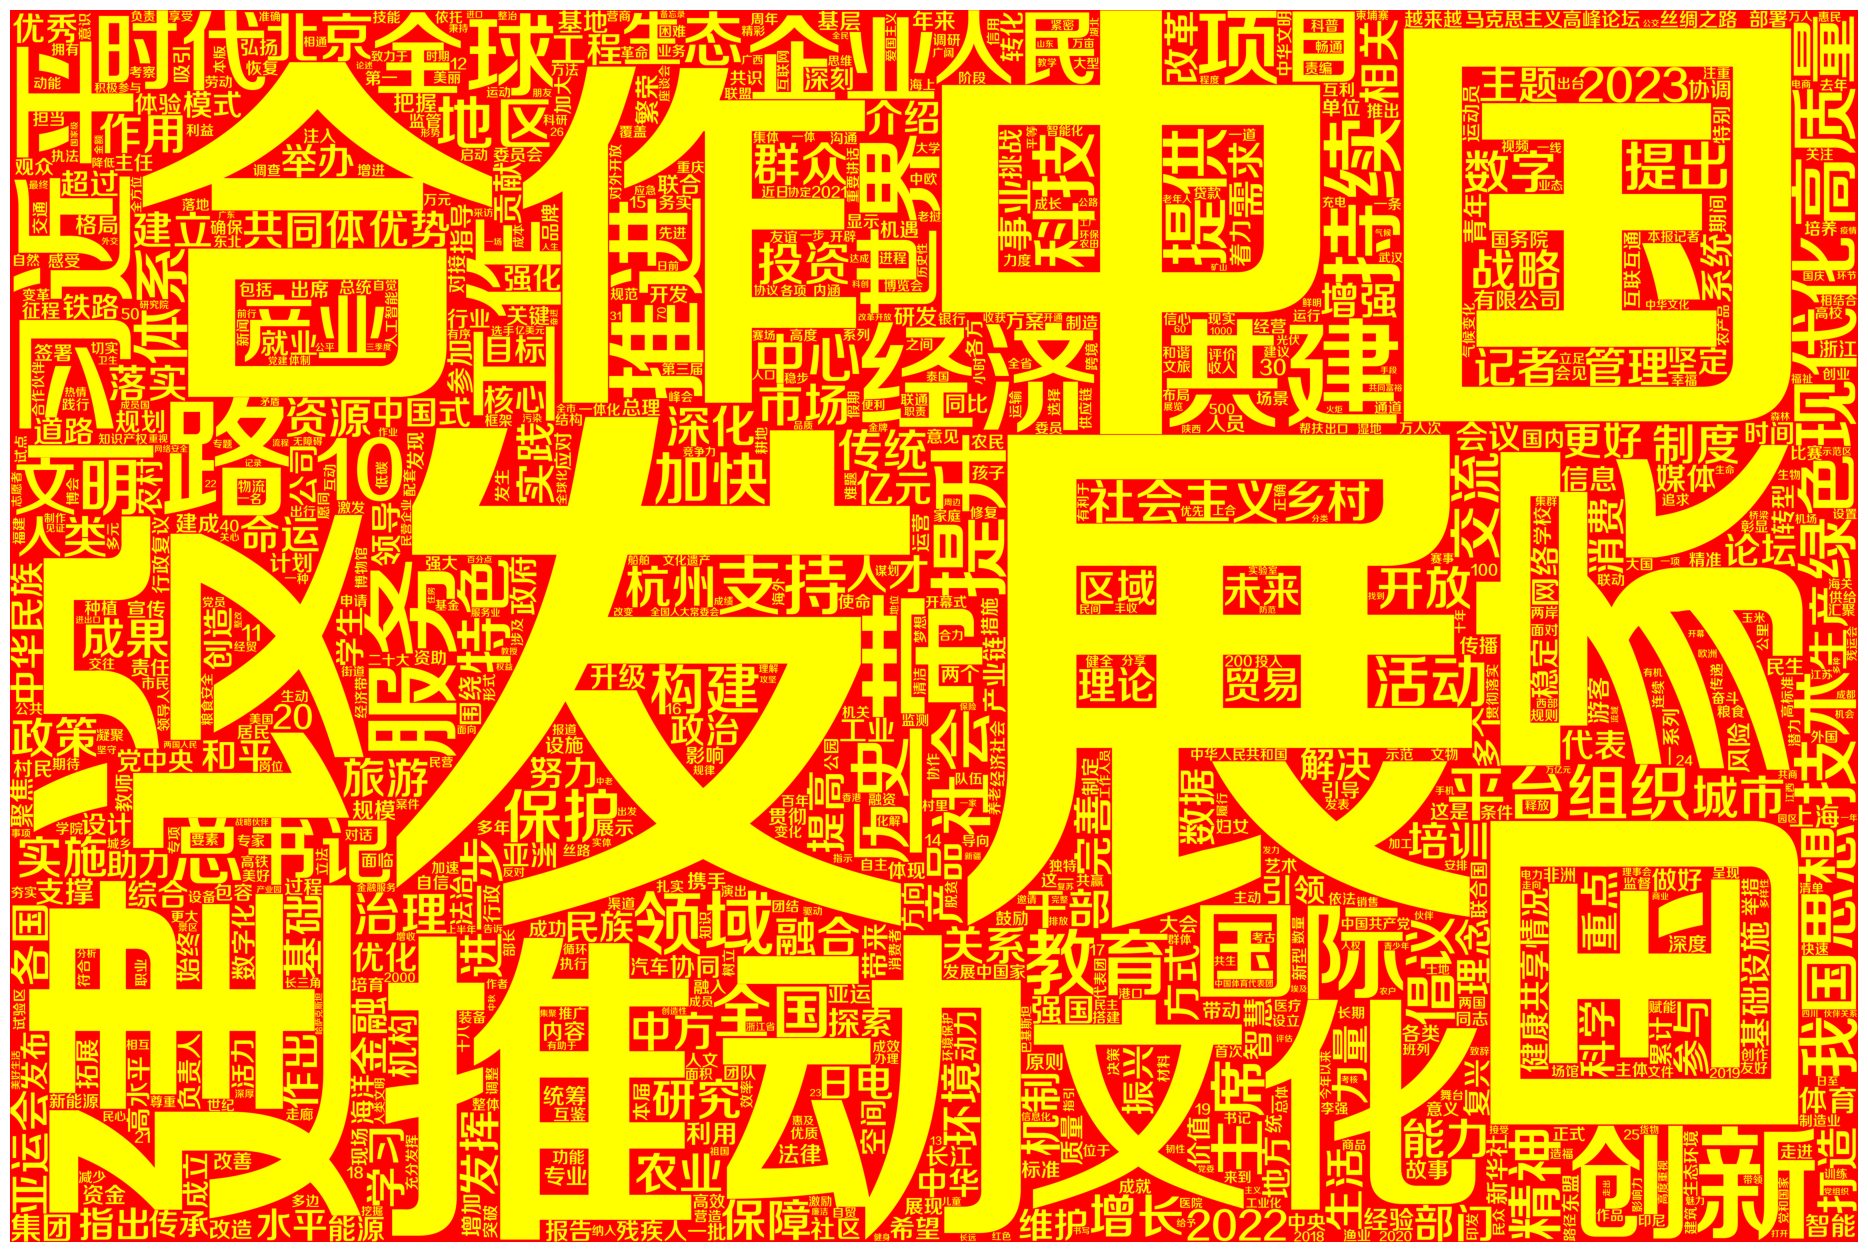

代码块执行时间：456.9963958263397 秒


In [138]:
draw_wordcloud(word_count)

In [223]:
import pandas as pd
word_ds=pd.DataFrame(word_count,index=[0])
word_ds=word_ds.T
word_ds.columns=['count']
word_ds.sort_values(by=['count'],ascending=False,inplace=True)

     count
发展   24279
中国   17036
合作   10473
建设   10094
国家    9859
推动    8385
文化    8010
一路    7629
习近平   7589
一带    7480
创新    6649
经济    6395
共建    6328
国际    6317
工作    6011
推进    5922
服务    5594
企业    4986
世界    4653
全球    4646


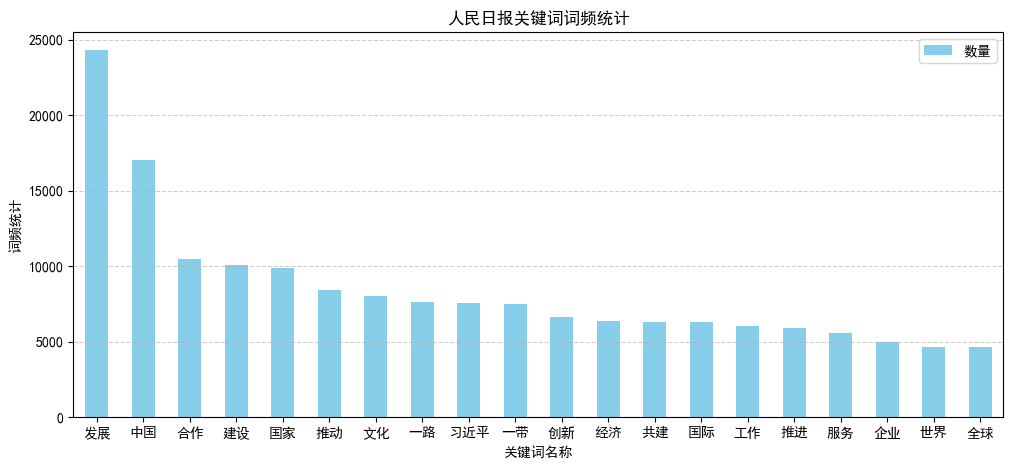

In [233]:
# from pylab import mpl
# mpl.rcParams['font.sans-serif'] = ['simhei'] # 指定默认字体
# mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
print(word_ds.head(20))
word_ds.head(20).plot(kind='bar', figsize=(12, 5), color='skyblue',title='人民日报关键词词频统计')
plt.xlabel('关键词名称')
plt.xticks(rotation=0)
plt.ylabel('词频统计')
plt.legend(['数量'])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [225]:
# 针对不同的领域进行分析
category = ['政治与国际关系', '经济与金融', '文化与教育', '社会与人民生活', '科技与创新', '军事与国防', '环境与可持续发展', '国内地区报道', '国际报道']
category_keywords_politics = ['政治与国际关系', '政治','党和政府', '国内政策', '国际外交', '国际合作', '政府工作', '政治改革', '政治动态', '政权', '外交政策', '政府机构', '党派政治', '领导人', '政治体制', '政治制度', '政治经济', '政治发展', '政治体制', '外交', '外交政策', '外交动态', '外交事务', '外交动态', '外交事务', '习近平']
category_keywords_economy = ['经济与金融', '经济', '金融', '经济发展', '贸易', '发展', '建设', '金融市场', '宏观经济政策', '产业发展', '经济改革', '经济动态', '经济增长', '经济政策', '经济动态', '经济体制', '经济体制', '经济领域', '经济政策', '经济改革']
category_keywords_culture = ['文化与教育', '文化活动', '艺术', '文化传承', '教育政策', '教育改革', '文化领域', '文化发展', '教育体制',  '文化教育', '文化发展', '文化传承', '文化发展', '文化', '教育', '传统文化', '中华文化', '传承', '历史', '学习', '诗词', '弘扬', '故宫', '书法', '博物馆', '国学']
category_keywords_society = ['社会与人民生活', '社会', '人民', '生活', '社会问题', '医疗卫生', '社会保障', '人民生活水平', '社会动态', '社会改革', '社会发展', '社会福利']
category_keywords_science = ['科技与创新', '科技', '创新', '科研发展', '科技政策', '创新技术', '信息技术', '科学研究', '科技领域', '科技创新', '技术发展']
category_keywords_military = ['军事与国防','国防', '军事', '军事动态', '军事政策', '军事技术', '军队', '国防建设', '军事演习', '军事合作', '官兵', '部队', '战士', '连队', '战友',  '战场', '装备', '军人', '强军', '海军', '飞行员', '官兵', '空军', '陆军', '导弹', '武警']
category_keywords_environment = ['环境与可持续发展', '环境', '可持续', '可持续发展', '环保政策', '可持续发展', '环境保护', '气候变化', '环境污染', '生态保护', '环境政策', '可持续资源利用']
category_keywords_domestic = ['国内地区报道', '国内', '地区', '地方政府工作', '地方动态', '地方经济', '地方政策', '地方社会', '地方文化', '地方发展', '地方改革']
category_keywords_internation = ['国际报道', '国际', '世界', '国际新闻', '国际事务', '国际合作', '国际外交', '国际关系', '国际经济', '国际政治', '国际动态']

In [226]:
word_count

{'中共中央政治局': 217,
 '会议': 1322,
 '审议': 252,
 '干部': 1982,
 '教育': 3988,
 '培训': 1764,
 '工作': 6011,
 '条例': 246,
 '全国': 2702,
 '规划': 1032,
 '二三': 14,
 '二七': 1,
 '中共中央': 163,
 '总书记': 4059,
 '习近平': 7589,
 '主持会议': 39,
 '建设': 10094,
 '高素质': 188,
 '干部队伍': 81,
 '先导性': 22,
 '基础性': 141,
 '战略性': 254,
 '工程': 1464,
 '推进': 5922,
 '中国': 17036,
 '特色': 2635,
 '社会主义': 2425,
 '伟大事业': 67,
 '党的建设': 233,
 '伟大工程': 32,
 '地位': 319,
 '作用': 2050,
 '贯彻': 877,
 '时代': 4542,
 '思想': 2985,
 '认真落实': 57,
 '组织路线': 25,
 '深刻': 1000,
 '领悟': 118,
 '两个': 836,
 '确立': 237,
 '决定性': 128,
 '意义': 736,
 '增强': 1588,
 '四个': 226,
 '意识': 428,
 '坚定': 1196,
 '自信': 729,
 '维护': 1407,
 '理想信念': 123,
 '宗旨': 121,
 '执政': 77,
 '本领': 214,
 '重点': 1755,
 '培养': 731,
 '造就': 119,
 '政治': 1407,
 '过硬': 100,
 '具备': 222,
 '领导': 1326,
 '现代化': 3740,
 '能力': 2034,
 '学习': 1809,
 '主题': 1654,
 '主线': 82,
 '坚持不懈': 69,
 '用党': 40,
 '创新': 6649,
 '理论': 1602,
 '凝心': 115,
 '铸魂': 145,
 '强基': 28,
 '固本': 60,
 '训练': 351,
 '贯穿': 226,
 '成长': 544,
 '周期': 138,
 '教育引导': 69,
 '树立': 435,

In [227]:
# 创建一个字典，用于存储每个领域的词频统计
category_word_counts = {}
# 遍历每个领域的关键词列表
for category_keywords in [category_keywords_politics, category_keywords_economy,category_keywords_culture,category_keywords_society,category_keywords_science,category_keywords_military,category_keywords_environment,category_keywords_domestic,category_keywords_internation]:
    # 初始化该领域的词频统计
    category_word_count = {}
    
    # 遍历关键词列表，统计词频
    for keyword in category_keywords:
        # 如果关键词存在于word_count中，将其词频添加到该领域的词频统计中
        if keyword in word_count:
            category_word_count[keyword] = word_count[keyword]
    
    # 将该领域的词频统计添加到category_word_counts字典中
    category_word_counts[category_keywords[0]] = category_word_count

category_word_counts_sum = {}
# 打印每个领域的词频统计
for category, word_count_ in category_word_counts.items():
    print(f'{category}词频统计：')
    sum = 0
    for keyword, count in word_count_.items():
        sum+=count
        print(f'{keyword}: {count}')
    category_word_counts_sum[category] = sum
    print()
print(category_word_counts_sum)

政治与国际关系词频统计：
政治: 1407
党和政府: 49
政权: 26
外交政策: 39
领导人: 418
政治体制: 8
政治经济: 20
外交: 280
外交事务: 9
习近平: 7589

经济与金融词频统计：
经济: 6395
金融: 1640
贸易: 1558
发展: 24279
建设: 10094
金融市场: 29
经济体制: 55

文化与教育词频统计：
艺术: 734
教育体制: 4
文化教育: 25
文化: 8010
教育: 3988
中华文化: 346
传承: 1167
历史: 3034
学习: 1809
诗词: 160
弘扬: 784
故宫: 11
书法: 20
博物馆: 465
国学: 5

社会与人民生活词频统计：
社会: 3087
人民: 4061
生活: 1825
医疗卫生: 130
社会保障: 161
社会福利: 4

科技与创新词频统计：
科技: 3480
创新: 6649
信息技术: 145
科学研究: 75
科技领域: 20

军事与国防词频统计：
国防: 173
军事: 104
军队: 130
国防建设: 7
官兵: 107
部队: 170
战士: 33
连队: 20
战友: 32
战场: 34
装备: 476
军人: 41
强军: 110
海军: 43
飞行员: 21
空军: 18
陆军: 14
导弹: 7
武警: 8

环境与可持续发展词频统计：
环境: 1932
环境保护: 377
气候变化: 480
环境污染: 85

国内地区报道词频统计：
国内: 913
地区: 2638

国际报道词频统计：
国际: 6317
世界: 4653
国际事务: 69

{'政治与国际关系': 9845, '经济与金融': 44050, '文化与教育': 20562, '社会与人民生活': 9268, '科技与创新': 10369, '军事与国防': 1548, '环境与可持续发展': 2874, '国内地区报道': 3551, '国际报道': 11039}


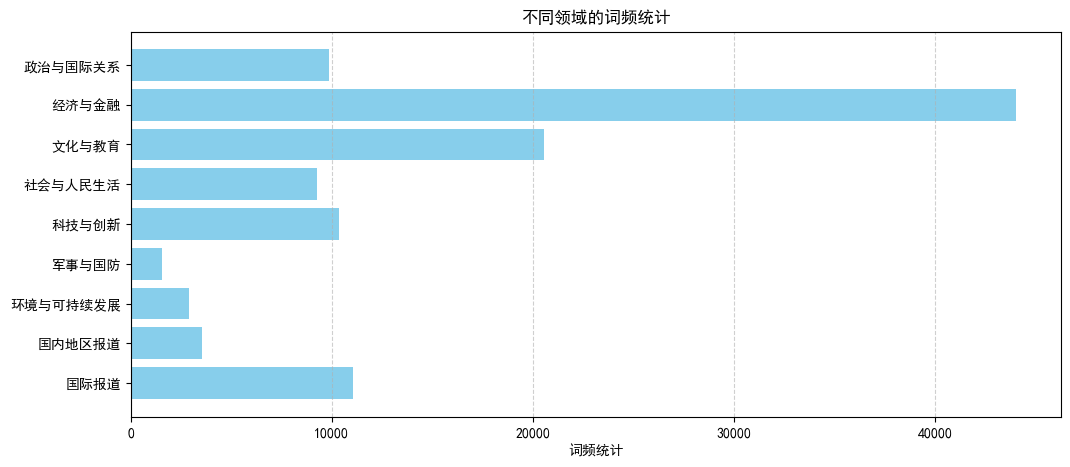

In [228]:
# 提取领域和词频数据
# 创建柱状图
plt.figure(figsize=(12, 5))
plt.barh(list(category_word_counts_sum.keys()), list(category_word_counts_sum.values()), color='skyblue')
plt.xlabel('词频统计')
plt.title('不同领域的词频统计')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.gca().invert_yaxis()  # 逆序显示

# 显示图表
plt.show()

In [231]:
def plot_word_count(word_count, title):
    plt.figure(figsize=(12, 5))
    plt.bar(word_count.keys(), word_count.values(), color='skyblue')
    plt.xlabel('领域')
    plt.ylabel('词频')
    plt.title(title)
    plt.xticks(rotation=0, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

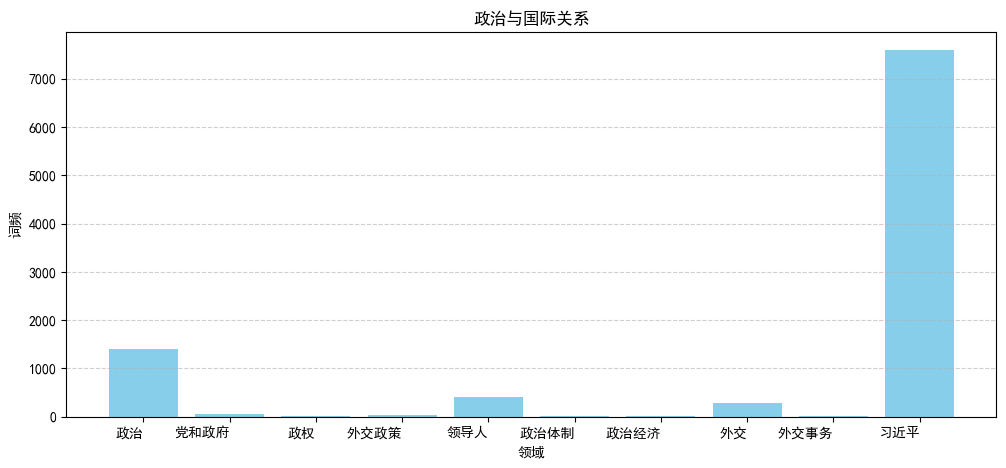

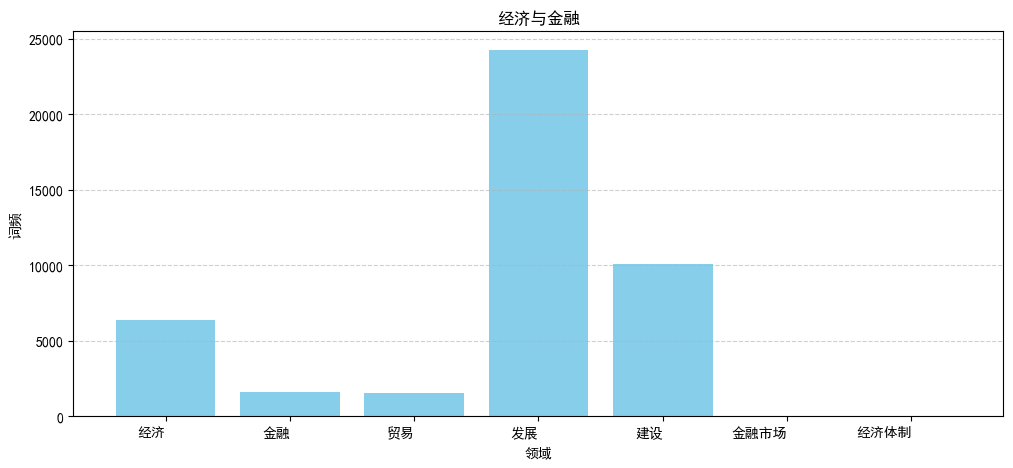

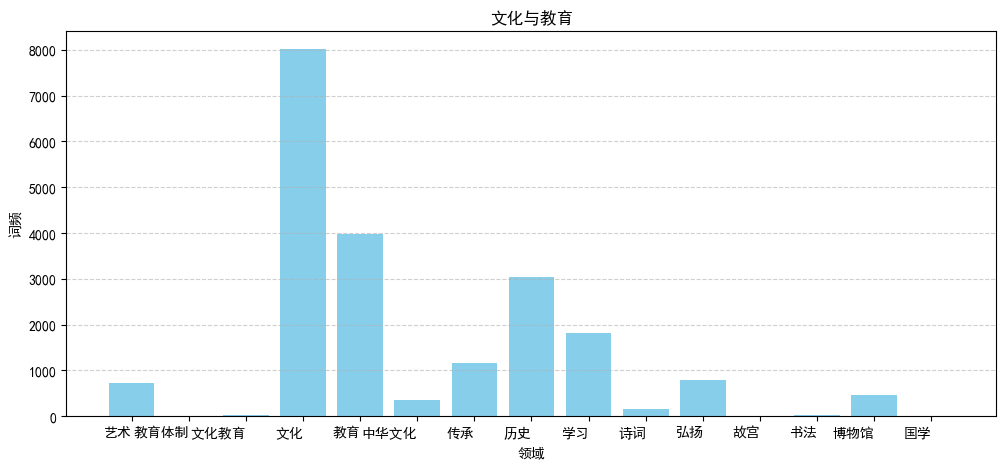

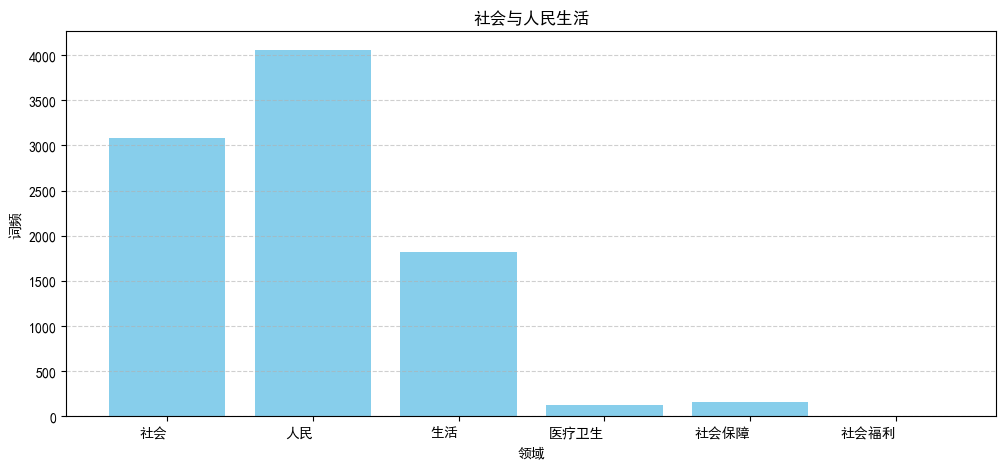

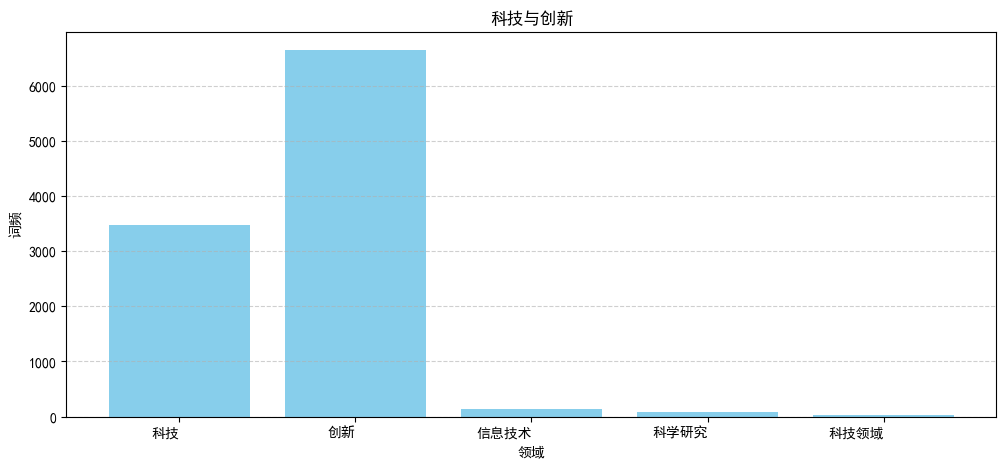

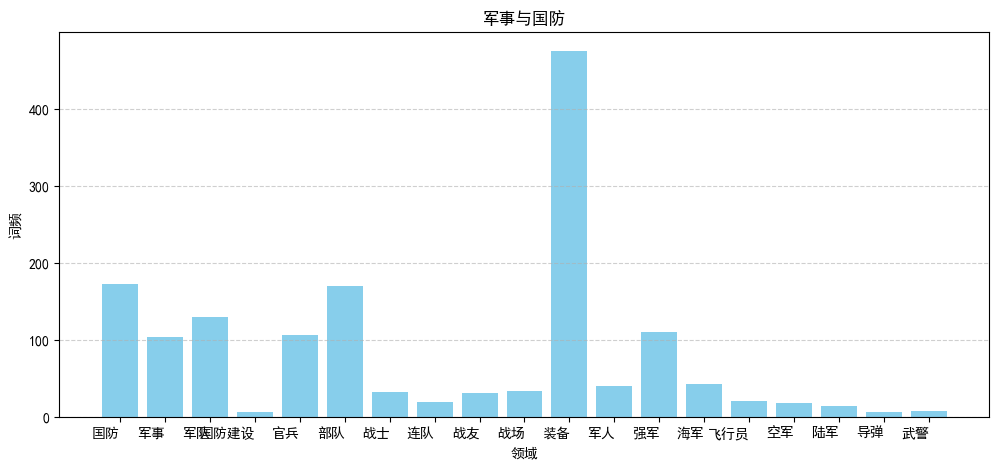

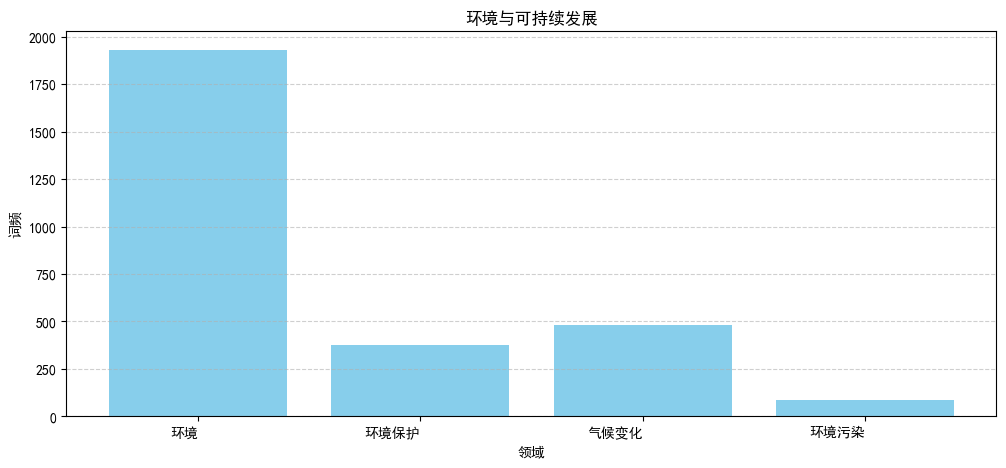

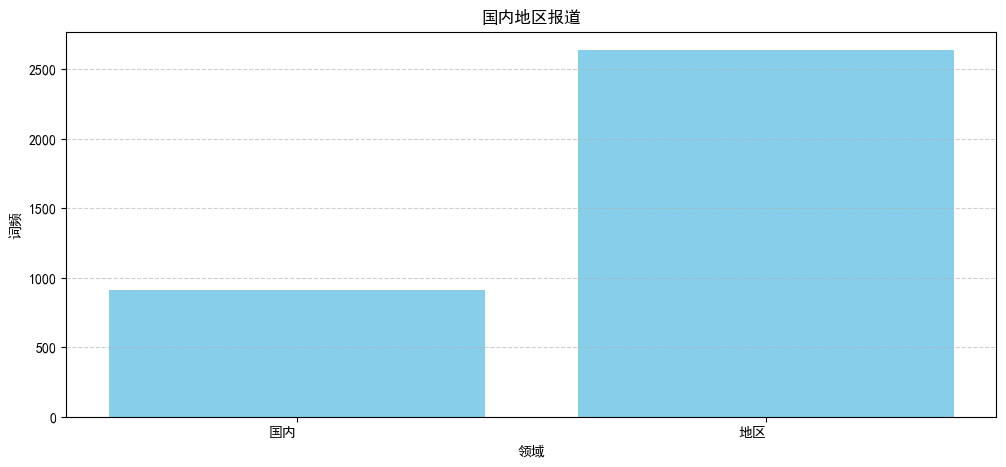

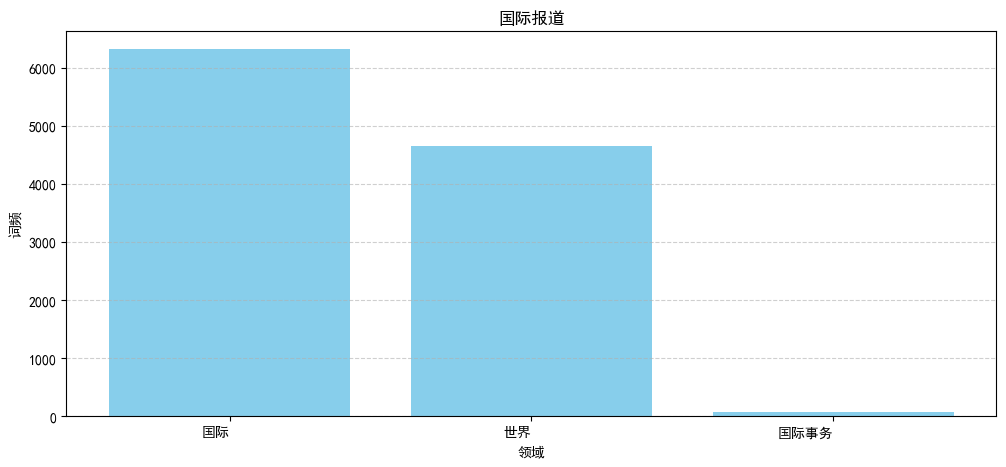

In [232]:
# 打印每个领域的词频统计
for category, word_count_ in category_word_counts.items():
    plot_word_count(word_count_, category)